In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla


# Cards Game with Monte Carlo


## Spin Glass card game recap

### Generating the data
We first sample out ground truth signal $ s^* =(s^*_1,\dots,s^*_N)$.  (In the code `s_star`)

$s^*_i=\pm 1$ with equal probability.

Then we build the matrix $Y_{ij}=\frac{s_i^*s_j^*}{\sqrt{N}}+\sqrt{\Delta}W_{ij}$, for $i\neq j$,  and  $Y_{ii}=0\;\, \forall\; i\in[N]$

Where $W_{ij}\sim N(0,1)$ come from a gaussian distribution and are all independent over $i<j$. Moreover $W_{ij}=W_{ji}$ so that $Y$ is symmetric.

$\{Y_{ij}\}_{i\in [N],j\in[N]}$ are our data.

### Recovering $s^*$

 The objective is to reconstruct the initial signal $ s^*$

You saw in the lectures that the estimator $\hat s(Y)$ that minimizes the expected (over the posterior ) square loss

\begin{equation}
\text{MSE}=\mathbb E_{s^*|Y}\left[\frac{1}{N}\sum_i \left(\hat s(Y)_i-s^*_i\right)^2\right]
\end{equation}

is the Bayes estimator (or minimum mean square error estimator (mmse)) given by the mean of the posterior

\begin{equation}
\hat s_{mmse}(Y)_i=\mathbb E_{s|Y} \left[ s_i\right].
\end{equation}

### Connection to systems in statistical physics
 Now consider a system of $N$ binary spins $s_1,\dots,s_N$, whose joint probability distribution is given by the posterior
 \begin{equation}
 P(s|Y)=\frac{1}{Z(Y)} e^{-H(s;Y)}, \qquad H(s;Y)=-\frac{1}{\Delta\sqrt{N}}\sum_{i<j}Y_{ij}s_is_j
 \end{equation}
 Then The Bayes estimator is nothing but the magnetizations of the spins $s_i$.
 Denoting the average with respect to $P(s|Y)$ with $\langle\cdot\rangle$ we   can write
 \begin{equation}
m_i=\langle s_i \rangle=\hat s_{mmse}(Y)_i.
 \end{equation}


For the single configuration $s$ we define its overlap with the ground truth $s^*$ as $\text{ov}(s,s^*)=\frac{1}{N}\sum_i s_is^*_i$

 In order to compute the magnetizations we implement a Monte Carlo that samples from the posterior.

 First we define the model

In [2]:
# Generating the planted signal (or ground truth)

def card_game_dataset(N, delta):

    s = np.random.choice([1., -1.], size=(N,1))
    W = np.random.randn(N, N) * np.sqrt(delta)
    W = np.tril(W) + np.tril(W, -1).T
    Y = s @ s.T / np.sqrt(N) + W

    return s, Y

N = 128  # Number of spins
Delta = 0.5  # Noise variance

np.random.seed(1234)

s_star, Y = card_game_dataset(N, Delta)

s_star = s_star.squeeze()

for i in range(N): # Set to zero the diagonal elements
    Y[i, i] = 0

## MCMC Implementation

We're given $Y$ and we want to sample form the posterior $P(s|Y)$.

MCMC methods are based on designing a markov chain whose stationary distribution is the distribution we want to sample from.

A markov chain is a stochastic process consisting in a sequence of random variables $\{s^{(t)}\}_{t\in\mathbb N}$.

We will initialize the Markov chain on a random state andthen update its state $s^{(t)}$.

There are many different Markov chains that have the same stationary probability. 

Here we will first implement the Metropolis rule for updating the state $s^{(t)}$.

### Metropolis

Let $s^{(t)}$ be the current state fo the Markov chain.

We draw an index $i\sim Unif([N])$ uniformly at random and propose to flip the spin $s_i$.

Let $s'=(s^{(t)}_1,\dots,s^{(t)}_{i-1},-s^{(t)}_i,s^{(t)}_{i+1},\dots,s^{(t)}_N)$ be the new proposed state.

We then compute the acceptance probability $P_{acc}(s^{(t)},s')=\min\{1, P(s'|Y)/P(s^{(t)}|Y)\}$

We accept the proposal ($s^{(t+1)}=s'$) with probability $P_{acc}(s^{(t)},s')$ and reject it ($s^{(t+1)}=s^{(t)}$) otherwise. In practice we draw random variable $u$ uniformly distributed in $[0,1]$.  If $u<P_{acc}(s^{(t)},s')$, we set $s^{(t+1)}=s'$, otherwise $s^{(t+1)}=s^{(t)}$.


### Special case of Boltzmann measures
When we want to sample from a probability of the form $P(s)=e^{-H(s)}$, the acceptance probability can be written as $P_{acc}(s^{(t)},s')=\min\{1, \exp(H(s^{(t)})-H(s'))\}$.
In the particular case of the planted spin glass we have 
\begin{equation}
    H(s')-H(s^{(t)})=\frac{2 s_i^{(t)}}{\Delta\sqrt{N}}\sum_k Y_{ik} s^{(t)}_k 
\end{equation}


Notice that the Hamiltonian is invariant under the transformation $s\to-s$, so when running the MCMC we might end up correlating either with $s$ or with $-s$. As a consequence $m$ might either be positive or negative.







In [3]:
def energy_difference(s, i, Y, Delta):
    '''
    Arguments:
    (s) current state, (i) flipped index, (Y) measurement matrix, (Delta) noise variance.
    Returns: 
    H(s')-H(s^t), where s' is obtained by flipping spin i in s^t.
    '''
    return 2*s[i]*np.einsum("k,k->", Y[i], s)/(np.sqrt(Y.shape[0])*Delta)


In [4]:
# Uniformly random initial configuration to start the MCMC
np.random.seed(0)
s0 = 2*np.random.binomial(n=1, p=0.5, size=[N])-1


In [5]:
# Here are some quantities we want to keep track of during the dynamics

overlaps = []  # Keeping track of the overlap through time
energies = [-np.einsum('ij,i,j->', Y, s0, s0)/(2*np.sqrt(N)*Delta)] # Keep track of all the states visited by the markov
state_history = [np.copy(s0)]


In [6]:
T = 10000
s = np.copy(s0)  # Current state
np.random.seed(10)
for t in range(T):

    # Returns an uniformly distributed integer between 0 and N-1 both included.
    i = np.random.randint(low=0, high=N)
    delta_H = energy_difference(s, i, Y, Delta)
    prob_accept = min([1, np.exp(-delta_H)])

    if (np.random.rand() < prob_accept):
        s[i] = -s[i]  # If accepted flip the spin
        energies.append(energies[-1]+delta_H)
    else:
        energies.append(energies[-1])

    overlaps.append(np.mean(s*s_star))
    state_history.append(np.copy(s))


Once your Monte Carlo finally runs, make some plots by running the cells you see below (up to the section "Computing averages with MCMC").

You will plot overlaps, energies and configurations as a function of time. Are you seeing what you would expect?

If you have time you can change the value of $\Delta$ (for example to something larger than 1) and look for the differences.

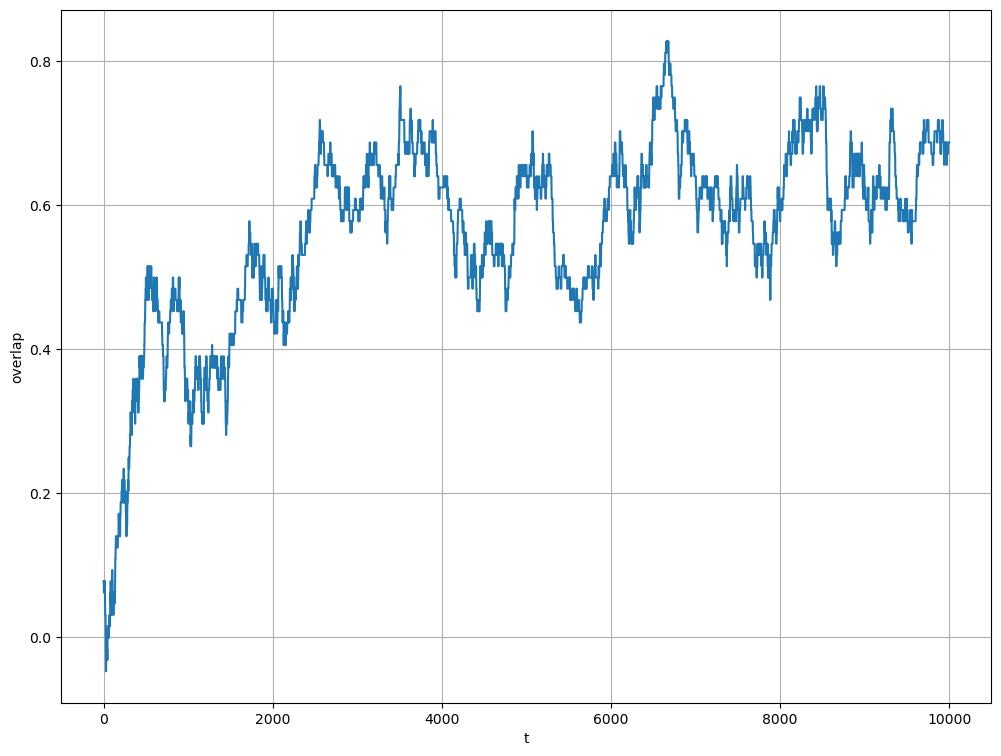

In [7]:
# Plot the overlap against the time

plt.figure(figsize=(12, 9))
plt.plot(overlaps)
plt.xlabel("t")
plt.ylabel("overlap")
plt.grid()


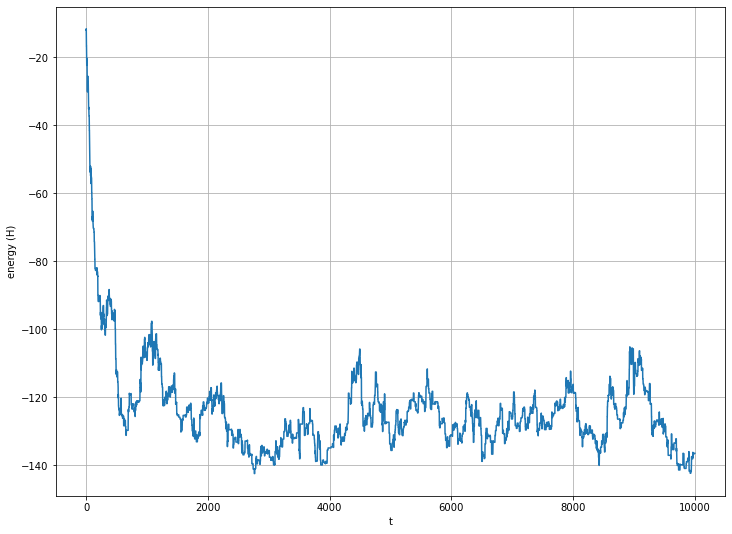

In [12]:
# Plot the overlap against the time
plt.figure(figsize=(12, 9))
plt.plot(energies)
plt.xlabel("t")
plt.ylabel("energy (H)")
plt.grid()


## Computing averages from the MCMC

Suppose we want to compute the average over the posterior of an observable $A(s)$
To do this we use the fact that (under the ergodicity assumption) the time averages over in the Markov chain converge to the ensemble averages. In formulas we have
\begin{equation}
\lim_{T\to\infty} \frac{1}{T}\sum_{t=0}^T A(s^{(t)})=\langle A \rangle=\sum_{s} P(s|Y) A(s)
\end{equation} 


In practicve things are more involved.

As you saw, the Monte Carlo needs some time to thermalize, before it starts sampling from the equilibrium measure. Configurations encountered in this initial *burn in* phase are not representative of the posterior, thus they should be discarded.
 Let $T_{therm}$ be the time until the Markov chain has reached equilibrium, and $T$ the maximum time of the simulation.

 Then we approximate
\begin{equation}
\langle A \rangle \approx \frac{1}{T-T_{therm}}\sum_{t=T_{therm}}^T A(s^{(t)})
\end{equation}

### Obtaining the MMSE estimator
Remember that $\hat s_{mmse}(Y)_i=m_i=\langle s_i\rangle=\mathbb E_{s|Y} \left[ s_i\right]$ is the minimum mean square error estimator. We can approximate the average by the procedure explained above


In [24]:
state_history = np.stack(state_history)

In [14]:
# Compute the mmse estimator from state_history using the procedure expalined above.
# What do you think is a reasonable value for T_therm?

T_therm = 3000
mmse_estimator = np.mean(state_history[T_therm:, :], axis=0)


In [15]:
mmse_estimator[:20]


array([ 0.10555635, -0.804028  ,  0.97771747, -0.83459506,  0.41779746,
        1.        ,  0.83459506, -0.93572347, -0.80088559,  0.21611198,
       -0.86916155, -0.71118412,  0.9245822 ,  1.        , -0.45979146,
        1.        ,  0.77660334,  0.60348522,  0.87058992,  1.        ])

In [16]:
# Now compute the mean square error of the estimator

mse = min([np.mean((mmse_estimator-s_star)**2),
          np.mean((mmse_estimator+s_star)**2)])
print("mean square error =", mse)


mean square error = 0.3816126679293127


## Estimating $T_{therm}$
 How do we know when our markov chain has thermalized? In general there is no good answer to this question, however several heuristics can be used
 

*   Look at when some observables (e.g. energy) are stationary (i.e. their value stops drifting and fluctuates around a constant level)
*   Initialize two independent Markov chains, one with random $s^{(0)}$ independent of $s^*$, and the other at $s^*$. Run the two Markov chains in parallel: $T_{therm}$ is the time at which the observables from the two chains have roughly the same value. This approach has the drawback of requiring the knowledge of $s^*$, which we normally don't have. However in some cases we know the structure of the ordered state (e.g. Ising where $s_i=1 \;\forall i$), so the method can be applied

Let's try this second approach: we run a Monte Carlo initialized from the planted configuration $s^*$ and compare the energy and overlap.


In [17]:
# First we save the overlaps and energies obtained with the random initialization

overlaps_rand_s0 = overlaps.copy()
energies_rand_s0 = energies.copy()


In [18]:
# Re execute the MCMC code, this time initializing s0=s_star. Remember to reinitialize all the variables!

s0 = np.copy(s_star)

overlaps = []  # Keeping track of the overlap through time
energies = [-np.einsum('ij,i,j->', Y, s0, s0)/(2*np.sqrt(N)*Delta)]
state_history = [np.copy(s0)]


In [19]:
T = 10000
s = np.copy(s0)  # Current state

for t in range(T):

    # Returns an uniformly distributed integer between 0 and N-1 both included.
    i = np.random.randint(low=0, high=N)
    delta_H = energy_difference(s, i, Y, Delta)
    prob_accept = min([1, np.exp(-delta_H)])

    if (np.random.rand() < prob_accept):
        s[i] = -s[i]  # If accepted flip the spin
        energies.append(energies[-1]+delta_H)
    else:
        energies.append(energies[-1])

    overlaps.append(np.mean(s*s_star))
    state_history.append(np.copy(s))


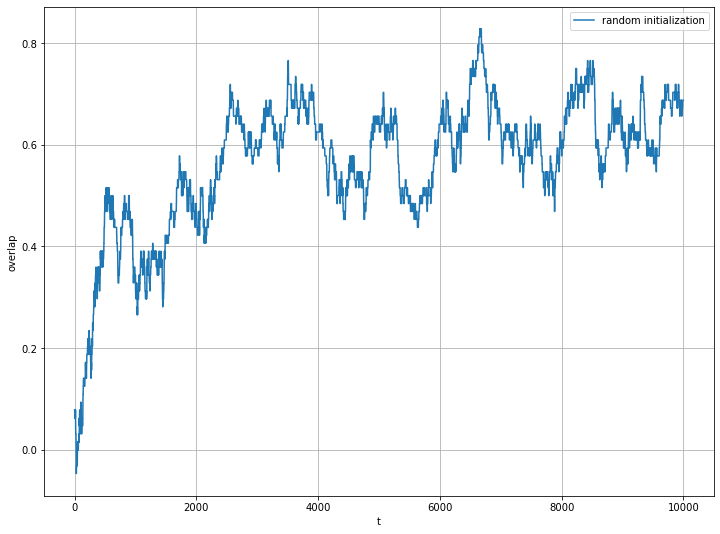

In [20]:
# Plot here overlaps from the simulation initialized with s0=s_star

plt.figure(figsize=(12, 9))
plt.plot(overlaps_rand_s0, label='random initialization')
plt.grid()
plt.xlabel('t')
plt.ylabel('overlap')
plt.legend()


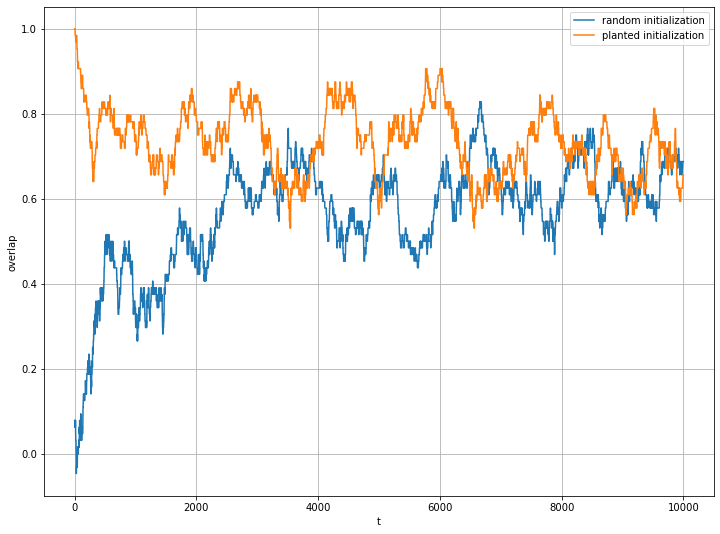

In [21]:
plt.figure(figsize=(12, 9))
plt.plot(overlaps_rand_s0, label='random initialization')
plt.plot(overlaps, label='planted initialization')
plt.grid()
plt.xlabel('t')
plt.ylabel('overlap')
plt.legend()


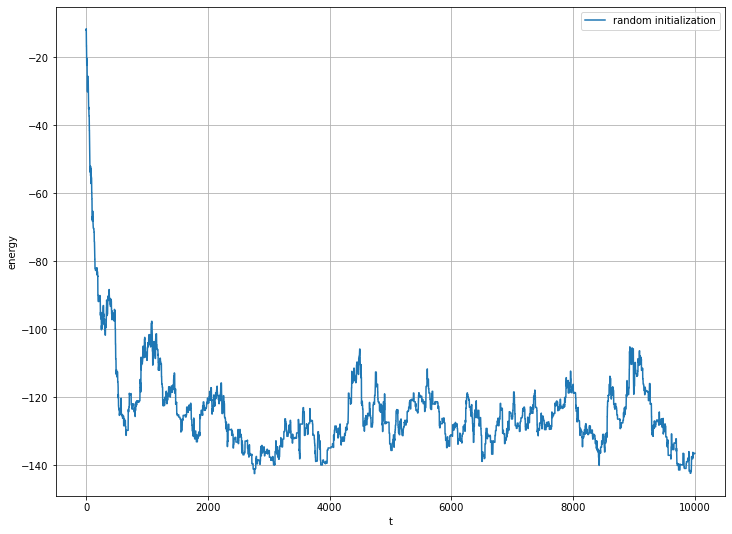

In [22]:
# Plot here energies from the simulation initialized with s0=s_star

plt.figure(figsize=(12, 9))
plt.plot(energies_rand_s0, label='random initialization')
plt.grid()
plt.xlabel('t')
plt.ylabel('energy')
plt.legend()


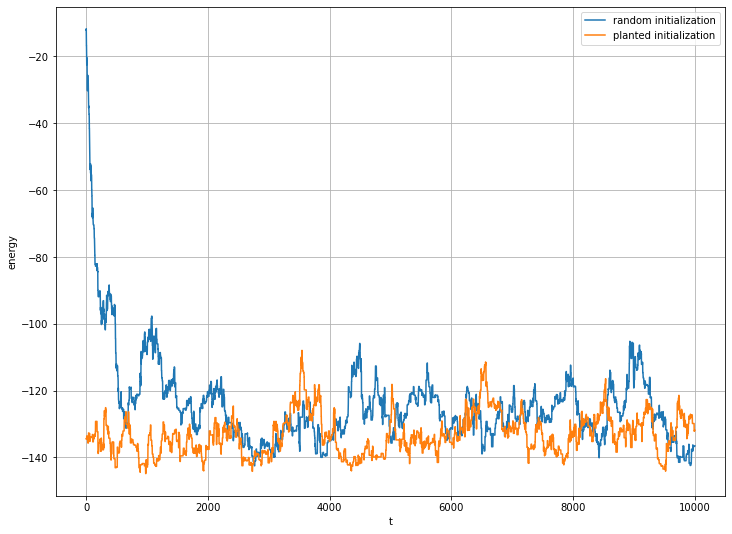

In [23]:
plt.figure(figsize=(12, 9))
plt.plot(energies_rand_s0, label='random initialization')
plt.plot(energies, label='planted initialization')
plt.grid()
plt.xlabel('t')
plt.ylabel('energy')
plt.legend()
